In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
os.getcwd()

path = '/Users/jojojacob/Documents/Data Science/Data Analysis/Data Sets/'
movies = pd.read_csv(path + "ratings_small.csv")
movies.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### Observations
- Total 4 variables
- timestamp is not useful in this case and hence may be deleted

In [3]:
# Drop timestamp coloumn
movies = movies.drop('timestamp', axis =1)

In [4]:
movies.head(8)

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
5,1,1263,2.0
6,1,1287,2.0
7,1,1293,2.0


In [5]:
movies.shape

(100004, 3)

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [7]:
movies.nunique()

userId      671
movieId    9066
rating       10
dtype: int64

- If you multiply total no of unique movies with unique users the qunatiity is much larger than 100004.
- This means that not all movies have been rated by all users
- Hence we should recommend movies not seen by particular users to them 

In [8]:
# Which user ahs rated the max number of movies
movies['userId'].value_counts().head(1)

547    2391
Name: userId, dtype: int64

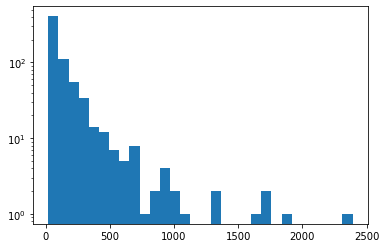

In [9]:
interactions = movies.groupby(['userId'])['movieId'].count()
plt.hist(interactions, bins= 30, log=True) # log was used as some of the values were too low
plt.show()

- This shows that only a very few users interacted with large no of movies and the no of people interactig with larger  no of movies is low

### Create user - item matrix
- there are many fucntions like pivot, stack-unstack in pandas to create this matrix

In [10]:
# Creating an user interaction matrix using pivot
interaction_matrix = movies.pivot(index='userId', columns = 'movieId', values = 'rating')

In [11]:

print(interaction_matrix.shape)
interaction_matrix.head(5)

(671, 9066)


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
interaction_matrix = interaction_matrix.fillna(0)

### Finding Similar users

In [48]:
# Define a function to find similar users
from sklearn.metrics.pairwise import cosine_similarity

def similar_users(user_id, interaction_matrix):
# compute similarity of each user to another user
    similarity =[]
    for user in range(1, interaction_matrix.shape[0]+1):
        sim = cosine_similarity([interaction_matrix.loc[user_id]], [interaction_matrix.loc[user]])
        similarity.append((user,sim))
                          
    # Sort by smilarity
    similarity.sort(key = lambda x:x[1], reverse = True)                   
    # Create a list of just the user ids
    most_similar_users = [tup[0] for tup in similarity]
    # Create a list of similarity score
    similarity_score = [tup[1] for tup in similarity]
    #remove users own id
    most_similar_users.remove(user_id)
    # remove user's own similarity score
    similarity_score.remove(similarity_score[0])
    return most_similar_users, similarity_score


In [49]:
similar_users(564, interaction_matrix)[0][:5]
# Using[0 ] gives us the user id and if we use [1], it will give the similarity score

[306, 102, 518, 232, 119]

### Creating colaborative based recommender system

In [59]:
def recommendations(user_id, num_of_movies, user_item_interactions):
    # Find the most similar users to the user id for which we wand to recommend movies
    most_similar_users = similar_users(user_id, user_item_interactions)[0]
    
    # find the movies which this users has already interacted with
      # create a set of lists using interaction_matrix, in this use colums and filter
      # use where to find the instances whree the user_id is >0. This will give the desired list
      # Since the matrix is pivot table we use user_id>0 to find the movies that user has graded
    movie_id = set(list(interaction_matrix.columns[np.where(interaction_matrix.loc[user_id]>0)]))  
    
    # Create an empty list to store the recommended movies
    recommendations = []
    # Copy those movies which are arleady seen by the user
    already_interacted = movie_id.copy()
    # Now we loop through each similar user from the list of most similar users
    for similar_user in most_similar_users:
        # The code has to be implemented till the length of recommended movies does not become equal to number of movies given in parameter
        if len(recommendations) < num_of_movies:
            # store all the movies interacted by each similar user to user_id
            # Create a new variable to store the list
            similar_user_movie_ids = set(list(interaction_matrix.columns[np.where(interaction_matrix.loc[similar_user]>0)]))
            # add those movies in the recommended list whiare present in similar_user_movie ids bt not present in the list
            recommendations.extend(list(similar_user_movie_ids.difference(already_interacted)))
            # now add all those movies into already_interacted which we aready added in reocmmendation
            already_interacted = already_interacted.union(similar_user_movie_ids)
        else:
            break
    return recommendations[:num_of_movies]

In [60]:
recommendations(564, 5, interaction_matrix)

[1537, 515, 1027, 2565, 524]

### New User
- in case of a new user, the collaborative based system wont work as the new user will not have interacted with any moveis
- In this case we need to use __rank based__ or __knowledge based__ recommedation systems
- In this case we can recommend the most popular movies 
- This type of problem is called __cold start problem__.
